### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- uses OSMNx, pandas, geopandas, rasterio
- may include content from ChatGPT or GitHub Copilot

### Tasks:
Create data quality control functions for the model inputs
- Check and remove null values
- Check negative values
- Correct errors from the upscaling done in ArcGIS

### Features
Roadmap betweem 10-18.10.2024:
1. [x] Test if errors arise from negative values (e.g. NaN set to -9999)
2. [x] Check slope values above the reasonable range (i.e., beyond 200%)
3. [x] Check the density2015 raster for anything odd (error raised when subtracting it from 1)
4. [x] Create input-loading tests in NetLogo
5. [x] Re-normalise values after ArcGIS upscaling
6. [x] Reproduce the model's math operations in Python

Roadmap between 21-25.10.2024:
1. [X] Check data format requirements from the NetLogo GIS extension
2. [X] Test displaying the values from a continuous var in NetLogo
2. [X] Check projection system settings in NetLogo GIS extension
3. [X] Create toy model to load inputs independent of other model features
4. [ ] Raster stack (netcdf) to be sure of registration, transform, etc. Get a raster summary (stats) from each layer.
5. [X] Check divisions by zero in the TI-C code


# Imports

In [1]:
import pandas as pd
import geopandas as gpd

import os
from pathlib import Path
import fnmatch
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiLineString, LineString
import json

import rasterio
from rasterio import features
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.mask import mask
from rasterio.plot import show, show_hist
from scipy.ndimage import distance_transform_edt

import ee
import geemap
import logging

import random 

# init

In [2]:
#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')
MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.11.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024
#  the 'case_city' variable defines the city we are working on. APS: Need to update the code below to change it from MUM to the variable name

case_city = 'MAN' #MUM MAN JAK

if case_city == 'MUM':
    
    AOI_gdf = gpd.read_file(AOI_path / MUM_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MUM_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MUM_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_150m\\')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_150m')
    ti_city_ascii_path = Path('../model/MUM/data/in/')

    gadm_var = 'NAME_3'

if case_city == 'MAN':
    
    AOI_gdf = gpd.read_file(AOI_path / MAN_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MAN_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MAN_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_150m\\')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_150m')
    ti_city_ascii_path = Path('../model/MAN/data/in/')

    gadm_var = 'NAME_2'

if case_city == 'JAK':
    
    AOI_gdf = gpd.read_file(AOI_path / JAK_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/JAK_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_150m\\')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_150m')
    ti_city_ascii_path = Path('../model/JAK/data/in/')

    gadm_var = 'NAME_2'

external_data_path = Path(r'D:\\Dropbox\\x\\_data')
ascii150_arcgis_path = Path(r"D:\\Dropbox\\x\\PostDoc\ASCII_150m")

def getFeatures(gdf):
    #Function to parse features from GeoDataFrame in such a manner that rasterio wants them
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def get_transform(raster):
    transform = raster.transform
    cell_width = transform[0]
    cell_height = -transform[4]
    area = cell_height*cell_width
    return cell_height, cell_width, area

# read the reference raster
with rasterio.open(ref_raster_path,'r') as src:
    ref_raster = src
    ref_meta = src.meta
    ref_height, ref_width, ref_area = get_transform(ref_raster)

%run ./ti_city_00_raster_functions.ipynb

# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# 1. Checking raster quality:
- negative values
- dimensions

In [3]:
if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.tif'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.tif'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif'

discrete_list  = [real_estate_path,
                  case_city + '_LIM_districts_GADM4_150m.tif',
                  case_city + '_LIM_exclusion_layer_150m.tif',
                  #case_city + '_POP_census_income_150m.tif',
                  case_city + '_TRA_roads_OSM_2024_L_all_150m.tif',
                  case_city + '_URB_tenure_150m.tif',
                  case_city + '_URB_urbanisation_1985_EOC_WUF_150m.tif',
                  case_city + '_URB_urbanisation_2000_EOC_WUF_150m.tif',
                  case_city + '_URB_urbanisation_2015_EOC_WUF_150m.tif',
                  case_city + '_LIM_non_residential_areas_150m.tif']
continuous_list = [case_city + '_LOC_airports_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_attractive_areas_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_CBDs_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                   case_city + '_LOC_health_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
                   case_city + '_LOC_malls_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_markets_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_schools_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_suburban_centres_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                   case_city + '_POP_density_normal_2000_WDPop_150m.tif',
                   case_city + '_POP_density_normal_2015_WDPop_150m.tif',
                   case_city + '_TRA_roads_OSM_2024_L_distance_normal_150m.tif',
                   case_city + '_URB_distance_urbanisation_2000_EOC_WUF_150m.tif',
                   case_city + '_URB_distance_urbanisation_2015_EOC_WUF_150m.tif',
                   case_city + '_HYD_water_distance_150m.tif']
slope_list=[case_city + '_DEM_slope_pct_TanDEM_X_150m.tif']

raster_list = [raster for raster in os.listdir(model_inputs_150m_path) if raster.endswith('.tif')]
for r in raster_list:
    print(r)

MAN_DEM_slope_pct_TanDEM_X_150m.tif
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif
MAN_HYD_water_distance_150m.tif
MAN_LIM_districts_GADM4_150m.tif
MAN_LIM_exclusion_layer_150m.tif
MAN_LIM_non_residential_areas_150m.tif
MAN_LOC_airports_cost_OSM_2024.tif
MAN_LOC_attractive_areas_cost_OSM_2024.tif
MAN_LOC_CBDs_cost_OSM_2024.tif
MAN_LOC_health_cost_OSM_2024.tif
MAN_LOC_malls_cost_OSM_2024.tif
MAN_LOC_markets_cost_OSM_2024.tif
MAN_LOC_schools_cost_OSM_2024.tif
MAN_LOC_suburban_centres_cost_OSM_2024.tif
MAN_POP_density_normal_2000_WDPop_150m.tif
MAN_POP_density_normal_2015_WDPop_150m.tif
MAN_TRA_roads_OSM_2024_L_all_150m.tif
MAN_TRA_roads_OSM_2024_L_distance_normal_150m.tif
MAN_URB_distance_urbanisation_2000_EOC_WUF_150m.tif
MAN_URB_distance_urbanisation_2015_EOC_WUF_150m.tif
MAN_URB_tenure_150m.tif
MAN_URB_urbanisation_1985_EOC_WUF_150m.tif
MAN_URB_urbanisation_2000_EOC_WUF_150m.tif
MAN_URB_urbanisation_2015_EOC_WUF_150m.tif


### Checking negative values

In [4]:
negative_list = []
print('checking the Discrete list')
for r in discrete_list:    
    with rasterio.open(model_inputs_150m_path/r) as raster:
        array = raster.read(1)
        if np.nanmin(array) < 0:
            print(r, 'has negative values')
            array = np.where(array < 0, 0, array)
            negative_list.append(r)
print('checking the Slope list')
for r in slope_list:
    with rasterio.open(model_inputs_150m_path/r) as raster:
        array = raster.read(1)
        if np.nanmin(array) < 0:
            print(r, 'has negative values')
            array = np.where(array < 0, 0, array)
            negative_list.append(r)
# check for nan values as -9999 and convert them to 0
print('checking the Discrete list')
for r in discrete_list:
    with rasterio.open(model_inputs_150m_path/r) as raster:
        array = raster.read(1)
        if np.isnan(array).any():
            print(r, 'Has NaN as -9999')
            array = np.where(np.nanmin(array) == -9999, 0, array)
            negative_list.append(r)
print('rasters to remove negative values from:', negative_list)

checking the Discrete list
checking the Slope list
checking the Discrete list
rasters to remove negative values from: []


In [5]:
# check the raster dimensions to make sure they are the same
reproject_raster_list = []

for raster in raster_list:
    with rasterio.open(model_inputs_150m_path/raster, 'r') as r:
        
        with rasterio.open(ref_raster_150_path, 'r') as ref_raster:
            if r.width != ref_raster.width:
                print('***',raster, 'has a different **width** from the reference with',r.width, '(versus',ref_raster.width, 'in the reference).')
                reproject_raster_list.append(raster)
                if r.height != ref_raster.height:
                    print('***',raster, 'has a different **height** from the reference with',r.height, '(versus',ref_raster.height, 'in the reference).')
            elif r.height != ref_raster.height:
                print('***',raster, 'has a different **height** from the reference with',r.height, '(versus',ref_raster.height, 'in the reference).')
                reproject_raster_list.append(raster)
            else: print(raster, 'dimensions are good.')
print('Rasters to reproject:', reproject_raster_list)     
        

MAN_DEM_slope_pct_TanDEM_X_150m.tif dimensions are good.
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif dimensions are good.
MAN_HYD_water_distance_150m.tif dimensions are good.
MAN_LIM_districts_GADM4_150m.tif dimensions are good.
MAN_LIM_exclusion_layer_150m.tif dimensions are good.
MAN_LIM_non_residential_areas_150m.tif dimensions are good.
MAN_LOC_airports_cost_OSM_2024.tif dimensions are good.
MAN_LOC_attractive_areas_cost_OSM_2024.tif dimensions are good.
MAN_LOC_CBDs_cost_OSM_2024.tif dimensions are good.
MAN_LOC_health_cost_OSM_2024.tif dimensions are good.
MAN_LOC_malls_cost_OSM_2024.tif dimensions are good.
MAN_LOC_markets_cost_OSM_2024.tif dimensions are good.
MAN_LOC_schools_cost_OSM_2024.tif dimensions are good.
MAN_LOC_suburban_centres_cost_OSM_2024.tif dimensions are good.
MAN_POP_density_normal_2000_WDPop_150m.tif dimensions are good.
MAN_POP_density_normal_2015_WDPop_150m.tif dimensions are good.
MAN_TRA_roads_OSM_2024_L_all_150m.tif dimensions are good.
MAN_TRA_

# 2. Normalizing continuous values

In [40]:
for r in continuous_list:
    with rasterio.open(model_inputs_150m_path/r, 'r') as raster:
        array = raster.read(1)
        try:
            array = np.where(np.isnan(array), 0, array)
            array = np.where(array < 0, 0, array)
            array = (array - np.nanmin(array))/(np.nanmax(array) - np.nanmin(array))
            array = np.round(array,3)
            #[0 if i < 0 else i for i in array]
            array = np.where(array < 0, 0, array)
        except Exception as e:
            print('error in raster', r, '\nerror',e)
        #plot_continuous_raster(array, r)
        # export the normalised array as a raster
        new_name = str(r.split('.')[0] + '_new_150m.tif')
        export_geotiff(raster = array,
                    out_transform = raster.transform, 
                    out_meta = raster.meta,
                    export_path = model_inputs_150m_path/new_name,
                    data_type=rasterio.float64)
        # rename the existing raster with '_old"
    try:
        # move the old raster to the '_old' folder and rename the new raster
        old_folder = model_inputs_150m_path / '_old'
        old_folder.mkdir(exist_ok=True)
        old_raster = old_folder/r
        if os.path.exists(old_raster): os.remove(old_raster)
        path_as_string = str(model_inputs_150m_path / r)
        shutil.move(model_inputs_150m_path/r, old_folder/r)

        new_raster_old_name = model_inputs_150m_path / new_name
        new_raster_new_name = Path(path_as_string)
        new_raster_old_name.rename(new_raster_new_name)
      
    except Exception as e:
        print('error in raster', r, '\nerror',e)
print('done')

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LOC_airports_cost_OSM_2024_new_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LOC_attractive_areas_cost_OSM_2024_new_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LOC_CBDs_cost_OSM_2024_new_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LOC_health_cost_OSM_2024_new_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LOC_malls_cost_OSM_2024_new_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LOC_markets_cost_OSM_2024_new_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\

C:\Users\ra42zek\AppData\Local\Temp\ipykernel_17440\2293176581.py:7: RuntimeWarning: invalid value encountered in divide
  array = (array - np.nanmin(array))/(np.nanmax(array) - np.nanmin(array))


Min value: nan , Max value: nan


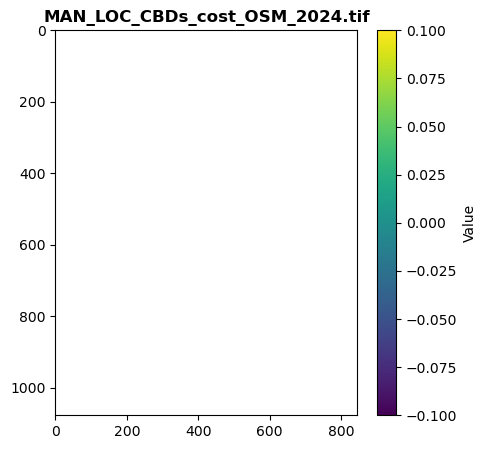

In [39]:
# APS 06/03/2025: checkiung the airport and attractive areas individually
r = continuous_list[2]
r_path = model_inputs_150m_path/r
with rasterio.open(r_path, 'r') as raster:
    array = raster.read(1)
    array = np.where(np.isnan(array), 0, array)
    array = (array - np.nanmin(array))/(np.nanmax(array) - np.nanmin(array))
    array = np.round(array,3).astype(np.float64)
    array = np.where(array < 0, 0, array)
    plot_continuous_raster(array, r)

# 3. Correct negative values

In [41]:
%run ./ti_city_00_raster_functions.ipynb
for raster in negative_list: 
    check_negative_raster(
        r = raster, 
        path=model_inputs_150m_path,
        ref_raster_path = ref_raster_150_path)

In [42]:
# if needed, co-register the raster to the reference raster
for r in reproject_raster_list:
    new_name = str(r.split('.')[0] + '_new_150m.tif')
    outfile = model_inputs_150m_path / new_name

    if raster in set(continuous_list):
        reproj_match(infile = model_inputs_150m_path/raster, 
                 match = ref_raster_150_path, 
                 outfile = outfile, 
                 resampling=Resampling.bilinear)
    elif raster in set(continuous_list):
        reproj_match(infile = model_inputs_150m_path/raster, 
                    match = ref_raster_150_path, 
                    outfile = outfile, 
                    resampling=Resampling.nearest)
    try:
        # move the old raster to the '_old' folder and rename the new raster
        old_folder = model_inputs_150m_path / '_old'
        old_folder.mkdir(exist_ok=True)
        old_raster = old_folder/r
        if os.path.exists(old_raster): os.remove(old_raster)
        path_as_string = str(model_inputs_150m_path / r)
        shutil.move(model_inputs_150m_path/r, old_folder/r)

        new_raster_old_name = model_inputs_150m_path / new_name
        new_raster_new_name = Path(path_as_string)
        new_raster_old_name.rename(new_raster_new_name)
      
    except Exception as e:
        print(e)

# 4. Export TIFFs as ASCIIs

In [43]:
for raster in raster_list[:2]: 
    print(raster.replace('.tif', '.asc'),  type(raster.replace('.tif', '.asc')))
    with rasterio.open(model_inputs_150m_path/raster, 'r') as r:
        print(r.dtypes)
        array = r.read(1)
        print(array.dtype)

MAN_DEM_slope_pct_TanDEM_X_150m.asc <class 'str'>
('float32',)
float32
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc <class 'str'>
('int16',)
int16


In [44]:
%run ./ti_city_00_raster_functions.ipynb
for raster in raster_list: 
    file_name = str(raster.replace('.tif', '.asc'))
    export_path = ascii150_path / file_name
    try:
        with rasterio.open(model_inputs_150m_path/raster, 'r') as r:
            export_raster_to_ascii(raster_obj = r.read(1),                             
                                export_path = export_path, 
                                ref_raster_path = ref_raster_150_path,
                                raster_data_type=r.dtypes[0])
    except Exception as e:
        print(e)
    print(str(export_path), 'exported')
print('done')

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\ASCII_150m\MAN_DEM_slope_pct_TanDEM_X_150m.asc exported
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\ASCII_150m\MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc exported
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\ASCII_150m\MAN_HYD_water_distance_150m.asc exported
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\ASCII_150m\MAN_LIM_districts_GADM4_150m.asc exported
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\ASCII_150m\MAN_LIM_exclusion_layer_150m.asc exported
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\ASCII_150m\MAN_LIM_non_residential_areas_150m.asc exported
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 0

# 5. Rename resampled ASCII files

In [45]:
# list all the files in the working dir

ti_city_files = []
for file in os.listdir(ti_city_ascii_path):
    if fnmatch.fnmatch(file, '*.asc'):
        ti_city_files.append(file)
ti_city_files

['airport.asc',
 'attractive2000.asc',
 'attractive2015.asc',
 'bu2000_dist.asc',
 'bu2015_dist.asc',
 'cbd.asc',
 'density2000.asc',
 'density2015.asc',
 'districts.asc',
 'exclusion.asc',
 'exclusion_ssp1.asc',
 'exclusion_ssp2.asc',
 'exclusion_ssp3.asc',
 'healthfacilities.asc',
 'landvalue.asc',
 'markets.asc',
 'road-presence.asc',
 'roads.asc',
 'schools.asc',
 'shoppingmalls.asc',
 'slope.asc',
 'structureplan.asc',
 'suburban.asc',
 'tenure.asc',
 'urban2000.asc',
 'urban2015.asc',
 'water.asc']

In [46]:
arcgis_ascii_files = []
for file in os.listdir(ascii150_path):
    if fnmatch.fnmatch(file, '*.asc'):
        arcgis_ascii_files.append(file)
arcgis_ascii_files

['MAN_DEM_slope_pct_TanDEM_X_150m.asc',
 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc',
 'MAN_HYD_water_distance_150m.asc',
 'MAN_LIM_districts_GADM4_150m.asc',
 'MAN_LIM_exclusion_layer_150m.asc',
 'MAN_LIM_non_residential_areas_150m.asc',
 'MAN_LOC_airports_cost_OSM_2024.asc',
 'MAN_LOC_attractive_areas_cost_OSM_2024.asc',
 'MAN_LOC_CBDs_cost_OSM_2024.asc',
 'MAN_LOC_health_cost_OSM_2024.asc',
 'MAN_LOC_malls_cost_OSM_2024.asc',
 'MAN_LOC_markets_cost_OSM_2024.asc',
 'MAN_LOC_schools_cost_OSM_2024.asc',
 'MAN_LOC_suburban_centres_cost_OSM_2024.asc',
 'MAN_POP_density_normal_2000_WDPop_150m.asc',
 'MAN_POP_density_normal_2015_WDPop_150m.asc',
 'MAN_TRA_roads_OSM_2024_L_all_150m.asc',
 'MAN_TRA_roads_OSM_2024_L_distance_normal_150m.asc',
 'MAN_URB_distance_urbanisation_2000_EOC_WUF_150m.asc',
 'MAN_URB_distance_urbanisation_2015_EOC_WUF_150m.asc',
 'MAN_URB_tenure_150m.asc',
 'MAN_URB_urbanisation_1985_EOC_WUF_150m.asc',
 'MAN_URB_urbanisation_2000_EOC_WUF_150m.asc',
 'MAN_URB

In [51]:
# build a renaming dictionary between the arcgis exports in the arcgis_ascii_files list and the TI City model inputs in the ti_city_files list
if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc'

renaming_dict = {'slope.asc': case_city + '_DEM_slope_pct_TanDEM_X_150m.asc', 
                 'exclusion.asc': case_city + '_lim_exclusion_layer_150m.asc', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.asc',
                 'structureplan.asc': case_city + '_LIM_non_residential_areas_150m.asc', # APS: MUM and JAK still need defining
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_LOC_airports_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                 'attractive2000.asc': case_city + '_LOC_attractive_areas_cost_OSM_2024.asc', # APS: I need to replace this file with the actual 2000 data
                 'attractive2015.asc': case_city + '_LOC_attractive_areas_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                 'cbd.asc': case_city + '_LOC_CBDs_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                 'healthfacilities.asc': case_city + '_LOC_health_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
                 'shoppingmalls.asc': case_city + '_LOC_malls_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                 'markets.asc': case_city + '_LOC_markets_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                 'schools.asc': case_city + '_LOC_schools_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                 'suburban.asc': case_city + '_LOC_suburban_centres_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                 'roads.asc': case_city + '_tra_roads_osm_2024_l_distance_normal_150m.asc', 
                 'bu2000_dist.asc': case_city + '_urb_distance_urbanisation_2000_eoc_wuf_150m.asc', 
                 'bu2015_dist.asc': case_city + '_urb_distance_urbanisation_2015_eoc_wuf_150m.asc', 
                 'tenure.asc': case_city + '_urb_tenure_150m.asc', 
                 'density2000.asc': case_city + '_pop_density_normal_2000_wdpop_150m.asc',
                 'density2015.asc': case_city + '_pop_density_normal_2015_wdpop_150m.asc', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_tra_roads_osm_2024_l_all_150m.asc', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.asc', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.asc',
                 'water.asc': case_city + '_hyd_water_distance_150m.asc'
}
# rasters not included in the above correpondence (yet): income, 1 files are 'stand-ins'

In [48]:
print('The renaming dictionary has', len(renaming_dict), 'entries')
for i in renaming_dict.values():
    print(i)


The renaming dictionary has 23 entries
MAN_DEM_slope_pct_TanDEM_X_150m.asc
MAN_lim_exclusion_layer_150m.asc
MAN_lim_districts_gadm4_150m.asc
MAN_LIM_non_residential_areas_150m.asc
MAN_LOC_airports_cost_OSM_2024.tif
MAN_LOC_attractive_areas_cost_OSM_2024.tif
MAN_LOC_attractive_areas_cost_OSM_2024.tif
MAN_LOC_CBDs_cost_OSM_2024.tif
MAN_LOC_health_cost_OSM_2024.tif
MAN_LOC_malls_cost_OSM_2024.tif
MAN_LOC_markets_cost_OSM_2024.tif
MAN_LOC_schools_cost_OSM_2024.tif
MAN_LOC_suburban_centres_cost_OSM_2024.tif
MAN_tra_roads_osm_2024_l_distance_normal_150m.asc
MAN_urb_distance_urbanisation_2000_eoc_wuf_150m.asc
MAN_urb_distance_urbanisation_2015_eoc_wuf_150m.asc
MAN_urb_tenure_150m.asc
MAN_pop_density_normal_2000_wdpop_150m.asc
MAN_pop_density_normal_2015_wdpop_150m.asc
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc
MAN_tra_roads_osm_2024_l_all_150m.asc
MAN_urb_urbanisation_2000_eoc_wuf_150m.asc
MAN_urb_urbanisation_2015_eoc_wuf_150m.asc


In [49]:
print(ti_city_ascii_path)

..\model\MAN\data\in


In [52]:
# code adapted from https://www.geeksforgeeks.org/python-shutil-copyfile-method/

success_list = []
fail_list = []
for key in renaming_dict.keys():
    source = ascii150_path / renaming_dict[key]
    dest = ti_city_ascii_path / key
    
    try :
        shutil.copyfile(source, dest)
        success_list.append(dest)
    
    # If Source is a file but destination is a directory
    except IsADirectoryError:
        print("Source is a file but destination is a directory.")
        fail_list.append(dest)
    
    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")
        fail_list.append(dest)

    # If source is a directory but destination is a file
    except NotADirectoryError:
        print("Source is a directory but destination is a file.")
        fail_list.append(dest)
    
    # For permission related errors
    except PermissionError:
        print("Operation not permitted.")
        fail_list.append(dest)
    
    # For other errors
    except:
        print("Error occurred while copying file:\n", source)
        fail_list.append(dest)
print('Tried to copy:', len(renaming_dict), 'files\n', 'Succesfully copied:', len(success_list), 'files\n','The files copied were:',)
print('\n'.join(''.join(str(sl)) for sl in success_list))
if len(fail_list) > 0:
    print('Failed to copy:', len(fail_list), 'files\n','The files not copied were:')
    print('\n'.join(''.join(str(sl)) for sl in fail_list))

Tried to copy: 23 files
 Succesfully copied: 23 files
 The files copied were:
..\model\MAN\data\in\slope.asc
..\model\MAN\data\in\exclusion.asc
..\model\MAN\data\in\districts.asc
..\model\MAN\data\in\structureplan.asc
..\model\MAN\data\in\airport.asc
..\model\MAN\data\in\attractive2000.asc
..\model\MAN\data\in\attractive2015.asc
..\model\MAN\data\in\cbd.asc
..\model\MAN\data\in\healthfacilities.asc
..\model\MAN\data\in\shoppingmalls.asc
..\model\MAN\data\in\markets.asc
..\model\MAN\data\in\schools.asc
..\model\MAN\data\in\suburban.asc
..\model\MAN\data\in\roads.asc
..\model\MAN\data\in\bu2000_dist.asc
..\model\MAN\data\in\bu2015_dist.asc
..\model\MAN\data\in\tenure.asc
..\model\MAN\data\in\density2000.asc
..\model\MAN\data\in\density2015.asc
..\model\MAN\data\in\landvalue.asc
..\model\MAN\data\in\road-presence.asc
..\model\MAN\data\in\urban2000.asc
..\model\MAN\data\in\urban2015.asc


# The end (for now).